# Analyzing the PokeDex
Let's take a look at what Pokemon there are to work with

In [1]:
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [2]:
IMAGE_DIR = "../input/pokemon-images-dataset"
image_size = 64
batch_size = 8
normalization_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # Convert channels from [0, 1] to [-1, 1]

In [3]:
normal_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*normalization_stats)]))

# Augment the dataset with mirrored images
mirror_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.RandomHorizontalFlip(p=1.0),
    T.ToTensor(),
    T.Normalize(*normalization_stats)]))

# Augment the dataset with color changes
color_jitter_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ColorJitter(0.5, 0.5, 0.5),
    T.ToTensor(),
    T.Normalize(*normalization_stats)]))

# Combine the datasets
dataset_list = [normal_dataset, mirror_dataset, color_jitter_dataset]
dataset = ConcatDataset(dataset_list)

dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=4, pin_memory=False)

Since these images have been normalized to [-1, 1],  we need to denormalize them in order to view them. Below is a denormalization function to do just that.

In [4]:
def denorm(image):
    return image * normalization_stats[1][0] + normalization_stats[0][0]

Now let's show a sample batch of real Pokemon images

In [5]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dataloader, nmax=64):
    for images, _ in dataloader:
        show_images(images, nmax)
        break

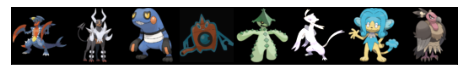

In [7]:
show_batch(dataloader)

Now that we know the visualization works, we can continue with making the GAN. First, we'll start with the discriminator

# Discriminator Models

Below I make a few possible discriminator models to try out

In [8]:
import torch.nn as nn

This is my first effort at making a discriminator for this dataset

In [9]:
disc_1 = nn.Sequential(
    # Input is 3 x 256 x 256
    nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 16 x 128 x 128
    
    nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 32 x 64 x 64
    
    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 64 x 32 x 32
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 128 x 16 x 16
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 256 x 8 x 8
    
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 512 x 4 x 4
    
    # With a 4x4, we can condense the channels into a 1 x 1 x 1 to produce output
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

In [10]:
disc_2 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
disc_2.fc.out_features = 1
disc_2

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
# Same as Discriminator 1, but with smaller kernel size
disc_3 = nn.Sequential(
    # Input is 3 x 256 x 256
    nn.Conv2d(3, 16, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 16 x 128 x 128
    
    nn.Conv2d(16, 32, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 32 x 64 x 64
    
    nn.Conv2d(32, 64, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 64 x 32 x 32
    
    nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 128 x 16 x 16
    
    nn.Conv2d(128, 256, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 256 x 8 x 8
    
    nn.Conv2d(256, 512, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 512 x 4 x 4
    
    # Additional layer to make it 2x2
    nn.Conv2d(512, 1024, kernel_size=2, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.3, inplace=True),
    # Layer Output: 512 x 2 x 2
    
    # With a 2x2, we can condense the channels into a 1 x 1 x 1 to produce output
    nn.Conv2d(1024, 1, kernel_size=2, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

In [12]:
disc_5 = nn.Sequential(
    # Input is 3 x 256 x 256
    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.15, inplace=True),
    # Layer Output: 64 x 128 x 128
    
    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.15, inplace=True),
    # Layer Output: 128 x 64 x 64
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.15, inplace=True),
    # Layer Output: 256 x 32 x 32
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.15, inplace=True),
    # Layer Output: 256 x 16 x 16
    
    nn.Conv2d(256, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.15, inplace=True),
    # Layer Output: 256 x 8 x 8
    
    nn.Conv2d(256, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.15, inplace=True),
    # Layer Output: 256 x 4 x 4
    
    # With a 4x4, we can condense the channels into a 1 x 1 x 1 to produce output
    nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

In [13]:
disc_64_1 = nn.Sequential(
    # Input is 3 x 64 x 64
    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 32 x 32 x 32
    
    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 64 x 16 x 16
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 8 x 8
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 256 x 4 x 4
    
    # With a 4x4, we can condense the channels into a 1 x 1 x 1 to produce output
    nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

# Generator Models

Below is a list of some possible generator models to try. These models are inverse operations of the discriminators.

Here's the first generator:

In [14]:
seed_size = 16

In [15]:
gen_1 = nn.Sequential(
    # Input seed_size x 1 x 1
    nn.ConvTranspose2d(seed_size, 512, kernel_size=4, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # Layer output: 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Layer output: 256 x 8 x 8
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 128 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Layer output: 64 x 32 x 32
    
    nn.ConvTranspose2d(64, 32, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # Layer output: 32 x 64 x 64
    
    nn.ConvTranspose2d(32, 16, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(16),
    nn.ReLU(True),
    # Layer output: 16 x 128 x 128
    
    nn.ConvTranspose2d(16, 3, kernel_size=4, padding=1, stride=2, bias=False),
    nn.Tanh()
    # Output: 3 x 256 x 256
)

In [16]:
# Generator matching Discriminator 3
gen_3 = nn.Sequential(
    # Input seed_size x 1 x 1
    nn.ConvTranspose2d(seed_size, 1024, kernel_size=2, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # Layer output: 1024 x 2 x 2
    
    nn.ConvTranspose2d(1024, 512, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # Layer output: 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Layer output: 256 x 8 x 8
    
    nn.ConvTranspose2d(256, 128, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 128 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Layer output: 64 x 32 x 32
    
    nn.ConvTranspose2d(64, 32, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # Layer output: 32 x 64 x 64
    
    nn.ConvTranspose2d(32, 16, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(16),
    nn.ReLU(True),
    # Layer output: 16 x 128 x 128
    
    nn.ConvTranspose2d(16, 3, kernel_size=2, padding=0, stride=2, bias=False),
    nn.Tanh()
    # Output: 3 x 256 x 256
)

In [17]:
# Generator with lots of upsampling weirdness
gen_4 = nn.Sequential(
    # Input seed_size x 1 x 1
    nn.ConvTranspose2d(seed_size, 1024, kernel_size=2, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # Layer output: 1024 x 2 x 2
    
    nn.ConvTranspose2d(1024, 512, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # Layer output: 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size=2, padding=0, stride=2, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Layer output: 256 x 8 x 8
    
    nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1, stride=9, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 128 x 64 x 64
    
    nn.ConvTranspose2d(128, 3, kernel_size=4, padding=0, stride=4, bias=False),
    nn.Tanh()
    # Output: 3 x 256 x 256
)

In [18]:
gen_5 = nn.Sequential(
    # Input seed_size x 1 x 1
    nn.ConvTranspose2d(seed_size, 256, kernel_size=4, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Layer output: 256 x 4 x 4
    
    nn.ConvTranspose2d(256, 256, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Layer output: 256 x 8 x 8
    
    nn.ConvTranspose2d(256, 256, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Layer output: 256 x 16 x 16
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 128 x 32 x 32
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Layer output: 128 x 64 x 64
    
    nn.ConvTranspose2d(64, 32, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # Layer output: 64 x 128 x 128
    
    nn.ConvTranspose2d(32, 3, kernel_size=4, padding=1, stride=2, bias=False),
    nn.Tanh()
    # Output: 3 x 256 x 256
)

In [19]:
gen_64_1 = nn.Sequential(
    # Input seed_size x 1 x 1
    nn.ConvTranspose2d(seed_size, 256, kernel_size=4, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # Layer output: 256 x 4 x 4
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 128 x 8 x 8
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Layer output: 64 x 16 x 16
    
    nn.ConvTranspose2d(64, 32, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # Layer output: 32 x 32 x 32
    
    nn.ConvTranspose2d(32, 3, kernel_size=4, padding=1, stride=2, bias=False),
    nn.Tanh()
    # Output: 3 x 256 x 256
)

# Model Testing

This is to make sure everything is the correct size

In [20]:
# Make some latent tensors to seed the generator
seed_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)
    
# Get some fake pokemon
generator=gen_64_1
to_device(generator, device)
fake_pokemon = generator(seed_batch)
print(fake_pokemon.size())

NameError: name 'device' is not defined

# GPU Setup
We should train this on a GPU, so I'll set that up right now

In [21]:
def get_training_device():
    # Use the GPU if possible
    if torch.cuda.is_available():
        return torch.device('cuda')
    # Otherwise use the CPU :-(
    return torch.device('cpu')

def to_device(data, device):
    # This moves the tensors to the device (GPU, CPU)
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dataloader: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

In [22]:
device = get_training_device()
device

device(type='cuda')

If the above output doesn't say something about 'cuda', then make sure the notebook is set up to run on the GPU accelerator.  

Now, we use the device dataloader class to send data to our chosen device:

In [23]:
# Using the dataloader from the top of the notebook, and the selected device
# create a device data loader
dev_dataloader = DeviceDataLoader(dataloader, device)

# **Training Functions**

## Discriminator

In [24]:
def train_discriminator(real_pokemon, disc_optimizer):
    # Reset the gradients for the optimizer
    disc_optimizer.zero_grad()
    
    # Train on the real images
    real_predictions = discriminator(real_pokemon)
    # real_targets = torch.zeros(real_pokemon.size(0), 1, device=device) # All of these are real, so the target is 0.
    real_targets = torch.rand(real_pokemon.size(0), 1, device=device) * (0.1 - 0) + 0 # Add some noisy labels to make the discriminator think harder.
    real_loss = F.binary_cross_entropy(real_predictions, real_targets) # Can do binary loss function because it is a binary classifier
    real_score = torch.mean(real_predictions).item() # How well does the discriminator classify the real pokemon? (Higher score is better for the discriminator)
    
    # Make some latent tensors to seed the generator
    latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)
    
    # Get some fake pokemon
    fake_pokemon = generator(latent_batch)
    
    # Train on the generator's current efforts to trick the discriminator
    gen_predictions = discriminator(fake_pokemon)
    # gen_targets = torch.ones(fake_pokemon.size(0), 1, device=device)
    gen_targets = torch.rand(fake_pokemon.size(0), 1, device=device) * (1 - 0.9) + 0.9 # Add some noisy labels to make the discriminator think harder.
    gen_loss = F.binary_cross_entropy(gen_predictions, gen_targets)
    gen_score = torch.mean(gen_predictions).item() # How well did the discriminator classify the fake pokemon? (Lower score is better for the discriminator)
    
    # Update the discriminator weights
    total_loss = real_loss + gen_loss
    total_loss.backward()
    disc_optimizer.step()
    return total_loss.item(), real_score, gen_score

## Generator

In [25]:
def train_generator(gen_optimizer):
    # Clear the generator gradients
    gen_optimizer.zero_grad()
    
    # Generate some fake pokemon
    latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)
    fake_pokemon = generator(latent_batch)
    
    # Test against the discriminator
    disc_predictions = discriminator(fake_pokemon)
    targets = torch.zeros(fake_pokemon.size(0), 1, device=device) # We want the discriminator to think these images are real.
    loss = F.binary_cross_entropy(disc_predictions, targets) # How well did the generator do? (How much did the discriminator believe the generator?)
    
    # Update the generator based on how well it fooled the discriminator
    loss.backward()
    gen_optimizer.step()
    
    # Return generator loss
    return loss.item()

## Results Viewer
We want to be able to see the results as we generate pokemon

In [26]:
import os
from torchvision.utils import save_image

RESULTS_DIR = 'results'
os.makedirs(RESULTS_DIR, exist_ok=True)

In [27]:
def save_results(index, latent_batch, show=True):
    # Generate fake pokemon
    fake_pokemon = generator(latent_batch)
    
    # Make the filename for the output
    fake_file = "result-image-{0:0=4d}.png".format(index)
    
    # Save the image
    save_image(denorm(fake_pokemon), os.path.join(RESULTS_DIR, fake_file), nrow=8)
    print("Result Saved!")
    
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_pokemon.cpu().detach(), nrow=8).permute(1, 2, 0))

# **Full Training**

In [28]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

# Static generation seed batch
fixed_latent_batch = torch.randn(64, seed_size, 1, 1, device=device)

def train(epochs, learning_rate, start_idx=1):
    # Empty the GPU cache to save some memory
    torch.cuda.empty_cache()
    
    # Track losses and scores
    disc_losses = []
    disc_scores = []
    gen_losses = []
    gen_scores = []
    
    # Create the optimizers
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    
    # Run the loop
    for epoch in range(epochs):
        # Go through each image
        for real_img, _ in tqdm(dev_dataloader):
            # Train the discriminator
            disc_loss, real_score, gen_score = train_discriminator(real_img, disc_optimizer)

            # Train the generator
            gen_loss = train_generator(gen_optimizer)
        
        # Collect results
        disc_losses.append(disc_loss)
        disc_scores.append(real_score)
        gen_losses.append(gen_loss)
        gen_scores.append(gen_score)
        
        # Print the losses and scores
        print("Epoch [{}/{}], gen_loss: {:.4f}, disc_loss: {:.4f}, real_score: {:.4f}, gen_score: {:.4f}".format(
            epoch+start_idx, epochs, gen_loss, disc_loss, real_score, gen_score))
        
        # Save the images and show the progress
        save_results(epoch + start_idx, fixed_latent_batch, show=False)
    
    # Return stats
    return disc_losses, disc_scores, gen_losses, gen_scores

# GPU Clean-up
Sometimes the Kaggle GPU runs out of memory. This block frees up the GPU and resends the device dataloader to the GPU

In [29]:
device = get_training_device()
device

device(type='cuda')

In [30]:
def debug_memory():
    import collections, gc, resource, torch
    print('maxrss = {}'.format(
        resource.getrusage(resource.RUSAGE_SELF).ru_maxrss))
    tensors = collections.Counter((str(o.device), o.dtype, tuple(o.shape))
                                  for o in gc.get_objects()
                                  if torch.is_tensor(o))
    for line in tensors.items():
        print('{}\t{}'.format(*line))
        
        
debug_memory()

maxrss = 2880436
('cuda:0', torch.float32, (64, 16, 1, 1))	1
('cpu', torch.float32, (16, 3, 4, 4))	2
('cpu', torch.float32, (16,))	16
('cpu', torch.int64, ())	103
('cpu', torch.float32, (32, 16, 4, 4))	2
('cpu', torch.float32, (32,))	32
('cpu', torch.float32, (64, 32, 4, 4))	6
('cpu', torch.float32, (64,))	60
('cpu', torch.float32, (128, 64, 4, 4))	6
('cpu', torch.float32, (128,))	68
('cpu', torch.float32, (256, 128, 4, 4))	6
('cpu', torch.float32, (256,))	116
('cpu', torch.float32, (512, 256, 4, 4))	2
('cpu', torch.float32, (512,))	64
('cpu', torch.float32, (1, 512, 4, 4))	1
('cpu', torch.float32, (64, 3, 7, 7))	1
('cpu', torch.float32, (64, 64, 1, 1))	1
('cpu', torch.float32, (64, 64, 3, 3))	3
('cpu', torch.float32, (256, 64, 1, 1))	4
('cpu', torch.float32, (64, 256, 1, 1))	2
('cpu', torch.float32, (128, 512, 1, 1))	3
('cpu', torch.float32, (128, 128, 3, 3))	4
('cpu', torch.float32, (512, 128, 1, 1))	4
('cpu', torch.float32, (1000, 2048))	1
('cpu', torch.float32, (1000,))	1
('cpu', t

/opt/conda/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:102: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


In [47]:
# Clean up everything
import gc
del dev_dataloader
del discriminator
del generator
dev_dataloader = None
discriminator = None
generator = None
gc.collect()
torch.cuda.empty_cache()

In [48]:
# Re-initialize the device dataloader
dev_dataloader = DeviceDataLoader(dataloader, device)

# Selecting Models
Here, I select the models I want to send to the GPU

In [49]:
# Discriminators
# discriminator = disc_1
# discriminator = disc_2
# discriminator = disc_3
# discriminator = disc_5

# 64 x 64 Discriminators
discriminator = disc_64_1

# Send to device
discriminator = to_device(discriminator, device)

In [50]:
# Generators
# generator = gen_1
# generator = gen_3
# generator = gen_5

# 64 x 64 Generators
generator = gen_64_1

# Send to device
generator = to_device(generator, device)

# Training Time
Here I'll edit hyperparameters and train the GAN

In [66]:
learning_rate = 0.0025
epochs = 50

In [52]:
history = train(epochs, learning_rate)


Epoch [1/50], gen_loss: 2.3489, disc_loss: 0.5905, real_score: 0.2851, gen_score: 0.9201
Result Saved!



Epoch [2/50], gen_loss: 2.2635, disc_loss: 0.7070, real_score: 0.3611, gen_score: 0.9619
Result Saved!



Epoch [3/50], gen_loss: 2.3930, disc_loss: 0.4716, real_score: 0.0884, gen_score: 0.9374
Result Saved!



Epoch [4/50], gen_loss: 2.9907, disc_loss: 0.4488, real_score: 0.0606, gen_score: 0.9695
Result Saved!



Epoch [5/50], gen_loss: 3.6528, disc_loss: 0.4052, real_score: 0.0146, gen_score: 0.9191
Result Saved!



Epoch [6/50], gen_loss: 3.3023, disc_loss: 0.3561, real_score: 0.0874, gen_score: 0.9522
Result Saved!



Epoch [7/50], gen_loss: 3.7718, disc_loss: 0.3781, real_score: 0.0415, gen_score: 0.9043
Result Saved!



Epoch [8/50], gen_loss: 3.4955, disc_loss: 0.3776, real_score: 0.1212, gen_score: 0.9678
Result Saved!



Epoch [9/50], gen_loss: 2.8817, disc_loss: 0.4130, real_score: 0.0622, gen_score: 0.8456
Result Saved!



Epoch [10/50], gen_loss: 3.0870, disc_loss: 0.4631, real_score: 0.0565, gen_score: 0.9283
Result Saved!



Epoch [11/50], gen_loss: 3.3238, disc_loss: 0.5421, real_score: 0.2064, gen_score: 0.9215
Result Saved!



Epoch [12/50], gen_loss: 3.3372, disc_loss: 0.4846, real_score: 0.0618, gen_score: 0.8505
Result Saved!



Epoch [13/50], gen_loss: 2.8216, disc_loss: 0.3165, real_score: 0.1397, gen_score: 0.9240
Result Saved!



Epoch [14/50], gen_loss: 2.7056, disc_loss: 0.4572, real_score: 0.0475, gen_score: 0.9601
Result Saved!



Epoch [15/50], gen_loss: 2.1321, disc_loss: 0.4861, real_score: 0.1371, gen_score: 0.9471
Result Saved!



Epoch [16/50], gen_loss: 2.4000, disc_loss: 0.4359, real_score: 0.0759, gen_score: 0.9600
Result Saved!



Epoch [17/50], gen_loss: 2.2257, disc_loss: 0.3140, real_score: 0.0926, gen_score: 0.9408
Result Saved!



Epoch [18/50], gen_loss: 2.6343, disc_loss: 0.4474, real_score: 0.1052, gen_score: 0.9036
Result Saved!



Epoch [19/50], gen_loss: 2.7919, disc_loss: 0.4561, real_score: 0.0426, gen_score: 0.9016
Result Saved!



Epoch [20/50], gen_loss: 2.5980, disc_loss: 0.4168, real_score: 0.0390, gen_score: 0.9665
Result Saved!



Epoch [21/50], gen_loss: 2.9709, disc_loss: 0.4615, real_score: 0.0598, gen_score: 0.9509
Result Saved!



Epoch [22/50], gen_loss: 3.5516, disc_loss: 0.5063, real_score: 0.0900, gen_score: 0.9362
Result Saved!



Epoch [23/50], gen_loss: 2.3240, disc_loss: 0.4060, real_score: 0.0848, gen_score: 0.9264
Result Saved!



Epoch [24/50], gen_loss: 2.9239, disc_loss: 0.3495, real_score: 0.0853, gen_score: 0.9726
Result Saved!



Epoch [25/50], gen_loss: 2.9271, disc_loss: 0.3934, real_score: 0.0412, gen_score: 0.9059
Result Saved!



Epoch [26/50], gen_loss: 3.6932, disc_loss: 0.5243, real_score: 0.1795, gen_score: 0.9546
Result Saved!



Epoch [27/50], gen_loss: 3.2242, disc_loss: 0.4762, real_score: 0.0298, gen_score: 0.9415
Result Saved!



Epoch [28/50], gen_loss: 3.2103, disc_loss: 0.3814, real_score: 0.0588, gen_score: 0.9483
Result Saved!



Epoch [29/50], gen_loss: 3.0489, disc_loss: 0.5115, real_score: 0.0773, gen_score: 0.9785
Result Saved!



Epoch [30/50], gen_loss: 2.6128, disc_loss: 0.4145, real_score: 0.0813, gen_score: 0.9334
Result Saved!



Epoch [31/50], gen_loss: 3.7485, disc_loss: 0.4650, real_score: 0.0443, gen_score: 0.9550
Result Saved!



Epoch [32/50], gen_loss: 2.0608, disc_loss: 0.4196, real_score: 0.1690, gen_score: 0.9508
Result Saved!



Epoch [33/50], gen_loss: 2.4947, disc_loss: 0.5709, real_score: 0.2526, gen_score: 0.9660
Result Saved!



Epoch [34/50], gen_loss: 2.6327, disc_loss: 0.5471, real_score: 0.2582, gen_score: 0.9482
Result Saved!



Epoch [35/50], gen_loss: 3.6358, disc_loss: 0.3329, real_score: 0.0313, gen_score: 0.9727
Result Saved!



Epoch [36/50], gen_loss: 2.4018, disc_loss: 0.3578, real_score: 0.0532, gen_score: 0.9314
Result Saved!



Epoch [37/50], gen_loss: 1.7815, disc_loss: 0.2953, real_score: 0.0843, gen_score: 0.9670
Result Saved!



Epoch [38/50], gen_loss: 3.0227, disc_loss: 0.3315, real_score: 0.0695, gen_score: 0.9319
Result Saved!



Epoch [39/50], gen_loss: 3.4922, disc_loss: 0.4306, real_score: 0.0094, gen_score: 0.9276
Result Saved!



Epoch [40/50], gen_loss: 2.9326, disc_loss: 0.6043, real_score: 0.0589, gen_score: 0.9455
Result Saved!



Epoch [41/50], gen_loss: 4.1543, disc_loss: 0.5597, real_score: 0.0699, gen_score: 0.9421
Result Saved!



Epoch [42/50], gen_loss: 3.4718, disc_loss: 0.4435, real_score: 0.1139, gen_score: 0.9642
Result Saved!



Epoch [43/50], gen_loss: 3.3431, disc_loss: 0.6479, real_score: 0.2670, gen_score: 0.9426
Result Saved!



Epoch [44/50], gen_loss: 2.8483, disc_loss: 0.3515, real_score: 0.0830, gen_score: 0.9310
Result Saved!



Epoch [45/50], gen_loss: 2.6843, disc_loss: 0.4285, real_score: 0.0483, gen_score: 0.9559
Result Saved!



Epoch [46/50], gen_loss: 2.0478, disc_loss: 0.5484, real_score: 0.2534, gen_score: 0.9436
Result Saved!



Epoch [47/50], gen_loss: 2.9626, disc_loss: 0.4886, real_score: 0.0670, gen_score: 0.9431
Result Saved!



Epoch [48/50], gen_loss: 2.9540, disc_loss: 0.3780, real_score: 0.0610, gen_score: 0.8867
Result Saved!



Epoch [49/50], gen_loss: 3.1986, disc_loss: 0.3882, real_score: 0.0635, gen_score: 0.9334
Result Saved!



Epoch [50/50], gen_loss: 2.5309, disc_loss: 0.4437, real_score: 0.1270, gen_score: 0.9420
Result Saved!


# View Results
Here, we will view the results for the PokeGAN using IPython's Image class

In [55]:
from IPython.display import Image

There are some blobs appearing at 10 epochs

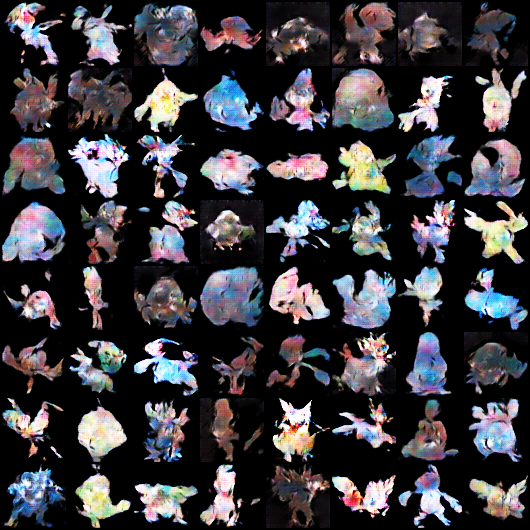

In [61]:
Image('./results/result-image-0010.png')

At 25 epochs the fake pokemon have more defined shapes:

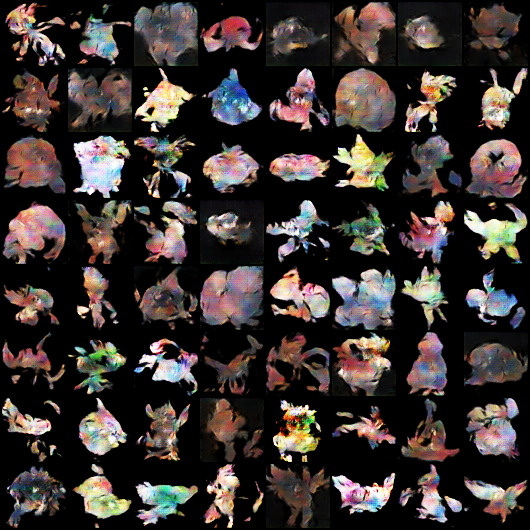

In [62]:
Image('./results/result-image-0025.png')

And by 50 epochs, more distinct features start appearing:

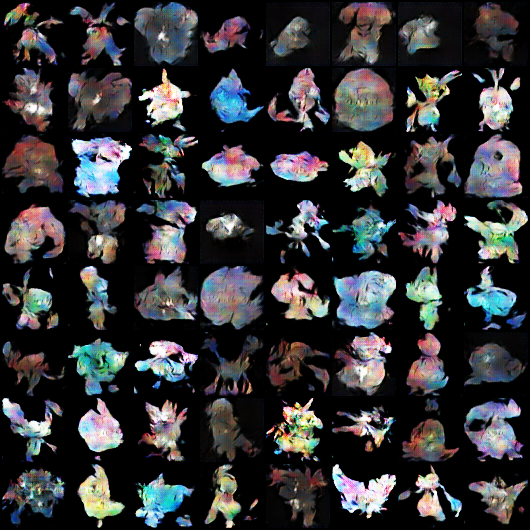

In [58]:
Image('./results/result-image-0050.png')

In [40]:
# Image('./results/result-image-0075.png')

In [41]:
# Image('./results/result-image-0100.png')

# Performance Analysis

Here are some plots to help tune the generator/discriminator. This shows losses and scores over time.

In [63]:
# Extract metrics
disc_losses, disc_scores, gen_losses, gen_scores = history

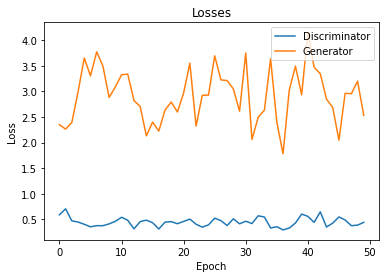

In [64]:
# Plot generator and discriminator losses
plt.plot(disc_losses, '-')
plt.plot(gen_losses, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

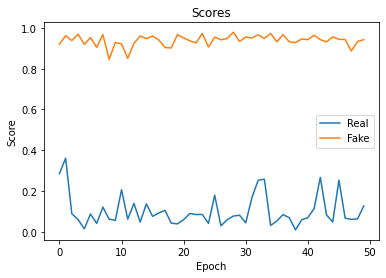

In [65]:
# Plots scores vs. epochs
plt.plot(disc_scores, '-')
plt.plot(gen_scores, '-')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

# Exporting Data
If the model works well, it definitely should be saved for later! Here I will export the weights for both the discriminator and generator, as well as send the notebook to Jovian.ml

In [ ]:
# Save generator and discriminator weights
torch.save(discriminator.state_dict(), 'discriminator-model.pth')
torch.save(generator.state_dict(), 'generator-model.pth')

In [54]:
# Commit to Jovian
!pip install jovian
import jovian
project_name = 'course-project-pokegan'
jovian.commit(project=project_name)

     |████████████████████████████████| 63 kB 1.1 MB/s eta 0:00:011
  Created wheel for uuid: filename=uuid-1.30-py3-none-any.whl size=6500 sha256=6d72a113e8455ef95a17ca38d69d5b7d32f18a7741d4c22fc364c88dca7d8e00
  Stored in directory: /root/.cache/pip/wheels/2a/ea/87/dd57f1ecb4f0752f3e1dbf958ebf8b36d920d190425bcdc24d
Successfully built uuid


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/jkleiber8/course-project-pokegan


<IPython.core.display.Javascript object>

# Acknowledgements

This wouldn't be possible without some good resources:

- Jovian.ml DCGAN example from PyTorch Zero to GANs Course: https://jovian.ml/aakashns/06b-anime-dcgan
- Tips and tricks about training GANs: https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9